In [1]:
import numpy as np
import jax.numpy as jnp
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
from v1diffusion import utils, transforms, operators, evolution, processing, metrics, examples

In [2]:
x=np.linspace(0,255,256)
y=np.linspace(0,255,256)
X,Y = np.meshgrid(x,y)

In [3]:
R = cv2.imread("../images/open_retinal_256.jpg",cv2.IMREAD_GRAYSCALE).astype(np.float32)
R/=255
R = 1-R
X,Y = np.meshgrid(x,y)
V = (X-128)**2+(Y-128)**2
R[V>15000]=0.7
R_h = cv2.GaussianBlur(R,(15,15),0.6)
R_hh = cv2.GaussianBlur(R,(15,15),1)

In [4]:
R_p = R.copy()
x=np.linspace(0,255,256)
y=np.linspace(0,255,256)
X,Y = np.meshgrid(x,y)
V = (X-128)**2+(Y-128)**2
R_p[V>15000]=0.7
R_ph = cv2.GaussianBlur(R_p,(15,15),0.6)

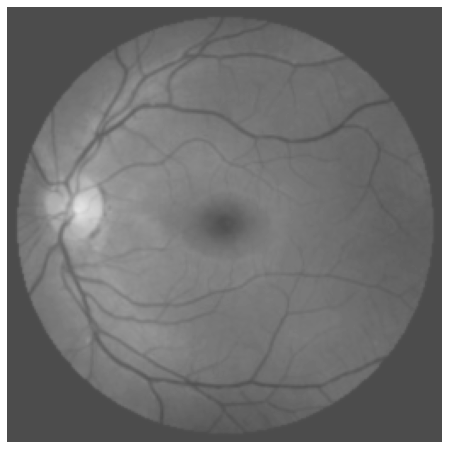

In [5]:
utils.imshow(R_h)

In [6]:
#Usual WaxOn
Ia = R_ph.copy()
Ja = transforms.lift_gaussian(Ia,sigma=10)
Ja = evolution.parallel_diffusion(Ja,4,beta=0.1)
Ic = transforms.project_max(Ja)
R_waxon = Ic.copy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 48.31it/s]


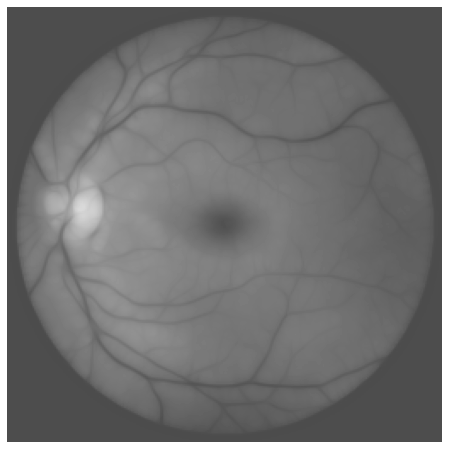

In [7]:
utils.imshow(R_waxon)

In [8]:
BETA = 0

# SE(2) unsharp

Here an image is lifted, unsharped using $X_3$, and projected 

In [9]:
sigma = 10

sf = 1

sharp_kernel = np.array([[0 , -sf   , 0],
                        [-sf, 4*sf+1,-sf],
                        [0  , -sf   , 0]])

Ja = transforms.lift_gaussian(R_ph,sigma)
Jb = evolution.orthogonal_diffusion(Ja, T=2, beta=BETA)
Jc = Ja + (Ja-Jb)*sf 
se2_unsharp = transforms.project_max(Jc)

r2_unsharp = cv2.filter2D(src=R_ph, ddepth=-2, kernel=sharp_kernel)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.31it/s]


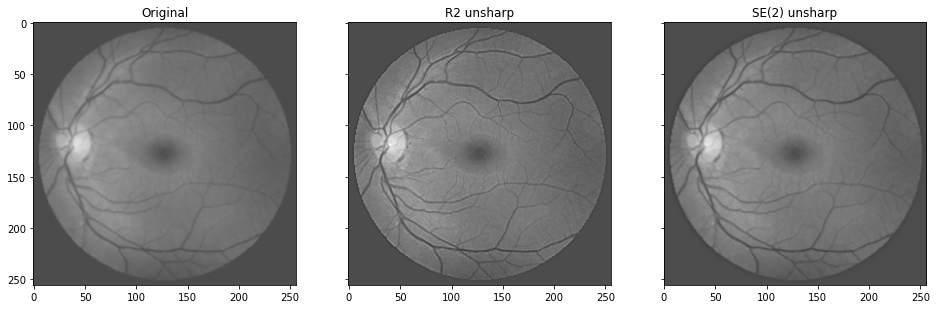

In [10]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
axs[0].set_title("Original")
axs[0].imshow(1-R_ph, cmap="gray", vmin=0, vmax=1)
axs[1].set_title("R2 unsharp")
axs[1].imshow(1-r2_unsharp, cmap="gray", vmin=0, vmax=1)
axs[2].set_title("SE(2) unsharp")
axs[2].imshow(1-se2_unsharp, cmap="gray", vmin=0, vmax=1)

# WaxOn-WaxOff with SE(2) unsharp as WaxOff 

WaxOn-WaxOff using the proposed unsharped filter as WaxOff step

In [11]:
sfs = [0,0.5,1,1.5,2]
#sfs = [0,2,4,6,8,10]
results = []

for sf in sfs:
    Ia = R_ph.copy()
    sigma = 100
    T1 = 3
    T2 = 0.5
    N = 4

    Ja = transforms.lift_gaussian(Ia,sigma)
    for n in range(N):
        #WaxOn
        Ja = evolution.parallel_diffusion(Ja,T1,beta=0.1)
        
        #Unsharp
        Jb = evolution.orthogonal_diffusion(Ja, T=T2, beta=BETA)
        Ja = Ja + (Ja-Jb)*sf 

    Ia = transforms.project_max(Ja)
    R_unsharp = Ia
    results.append(R_unsharp)
    #utils.imshow(R_f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.89it/s]


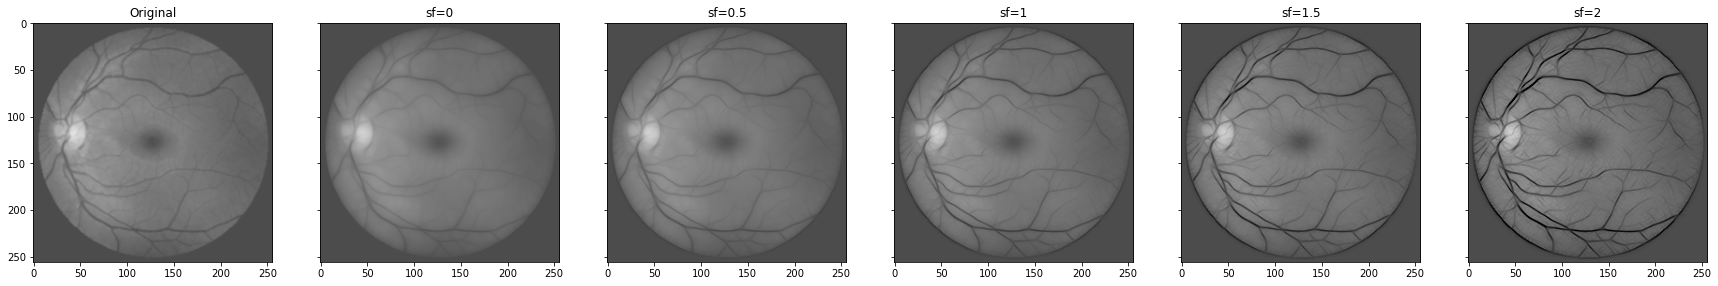

In [12]:
fig, axs = plt.subplots(1, len(results)+1, sharex=True, sharey=True, figsize=(30,10))
axs[0].set_title("Original")
axs[0].imshow(1-R_ph, cmap="gray", vmin=0, vmax=1)
for i in range(1, len(results)+1):
    axs[i].set_title("sf="+str(sfs[i-1]))
    axs[i].imshow(1-results[i-1], cmap="gray", vmin=0, vmax=1)

# SE(2) unsharp used as a preprocessing step

In [13]:
C_h = cv2.Canny((R_ph*255).astype(np.uint8), 15, 150)
C_hh = cv2.Canny((R_hh*255).astype(np.uint8), 15, 150)
C_wax = cv2.Canny((np.array(results[4])*255).astype(np.uint8), 30, 150)

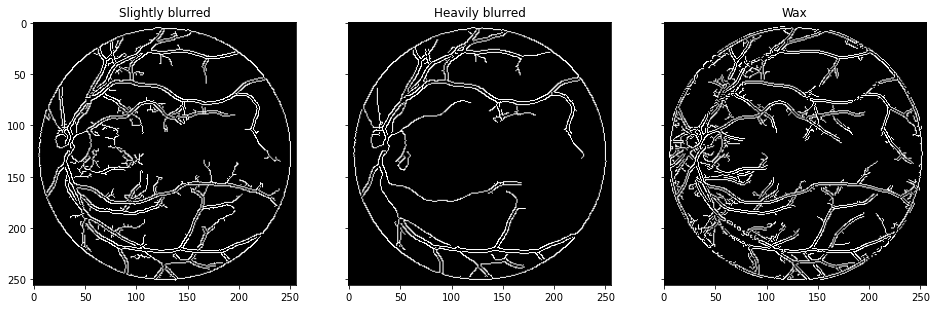

In [14]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
axs[0].set_title("Slightly blurred")
axs[0].imshow(C_h, cmap="gray")
axs[1].set_title("Heavily blurred")
axs[1].imshow(C_hh, cmap="gray")
axs[2].set_title("Wax")
axs[2].imshow(C_wax, cmap="gray")

# Comparison between SE(2) and $\mathbb R^2$ unsharp as WaxOff steps

Here the two unsharp operators, the classic one over $\mathbb R^2$ and the proposed one over $SE(2)$, are compared

In [15]:
sf = 1
sharp_kernel = np.array([[0 , -sf   , 0],
                        [-sf, 4*sf+1,-sf],
                        [0  , -sf   , 0]])

Ia = R_ph.copy()
sigma1 = 100
T1 = 3
T2 = 0.5
N = 4

Aa = transforms.lift_gaussian(Ia,sigma1)
Ba = transforms.lift_gaussian(Ia,sigma1)
for n in range(N):
    #WaxOn
    Aa = evolution.parallel_diffusion(Aa,T1,beta=0.1)
    Ba = evolution.parallel_diffusion(Ba,T1,beta=0.1)
    
    Ba = transforms.lift_gaussian(
        cv2.GaussianBlur(
            cv2.filter2D(src=
                         transforms.project_max(Ba)
                         , ddepth=-2, kernel=sharp_kernel)
            ,(15,15),0.9)
        ,sigma1)
    
    #Unsharp
    Ab = evolution.orthogonal_diffusion(Aa, T=T2, beta=BETA)
    Aa = Aa + (Aa-Ab)*sf 
    
    Ba = transforms.lift_gaussian(
        cv2.GaussianBlur(
            cv2.filter2D(src=
                         transforms.project_max(Ba)
                         , ddepth=-2, kernel=sharp_kernel)
            ,(15,15),0.9)
        ,sigma1)

se2_wax = transforms.project_max(Aa)
r2_wax = transforms.project_max(Ba)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.98it/s]
